<!--NAVIGATION-->
< [In Depth: Linear Regression](05.06-Linear-Regression.ipynb) | [Contents](Index.ipynb) | [In-Depth: Decision Trees and Random Forests](05.08-Random-Forests.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# In-Depth: Support Vector Machines

# 深入：支持向量机

> Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression.
In this section, we will develop the intuition behind support vector machines and their use in classification problems.

支持向量机（SVMs）是有监督学习算法中既能分类和回归的特别强大灵活的工具。本节中，我们会介绍支持向量机背后的机制以及它们在分类问题中的应用。

> We begin with the standard imports:

首先导入我们需要的包：

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 设置Seaborn样式输出图表
import seaborn as sns; sns.set()

## Motivating Support Vector Machines

## 走进支持向量机

> As part of our disussion of Bayesian classification (see [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb)), we learned a simple model describing the distribution of each underlying class, and used these generative models to probabilistically determine labels for new points.
That was an example of *generative classification*; here we will consider instead *discriminative classification*: rather than modeling each class, we simply find a line or curve (in two dimensions) or manifold (in multiple dimensions) that divides the classes from each other.

在朴素贝叶斯分类中（参见[深入：朴素贝叶斯分类](05.05-Naive-Bayes.ipynb)），我们学习了描述每个底层分类的简单模型，和使用这些生成模型来预测新数据点的概率标签的方法。那是*生成分类*的一个例子；这里我们考虑不去使用*判别式分类*：与其对每个类别进行建模，我们试图简单的寻找到一条曲线（二维空间）或流形（多维空间）能将每个类别区分出来。

> As an example of this, consider the simple case of a classification task, in which the two classes of points are well separated:

作为一个例子，考虑下面的分类的简单任务，两种类别的点已经很好的分开了：

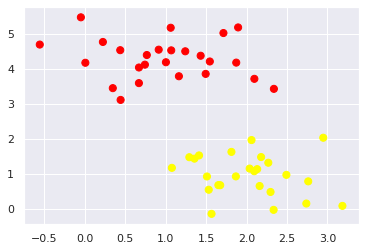

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

> A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification.
For two dimensional data like that shown here, this is a task we could do by hand.
But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

一个线性判别分类器会试图在两个分类数据间画出一条直线，通过这样创建一个分类模型。对于像上面一样的二位数据，这个任务可以手工完成。但是我们立刻就会碰到问题：这里存在多条可能的直线能完美的划分两个分类。

> We can draw them as follows:

我们可以画出下面的直线：

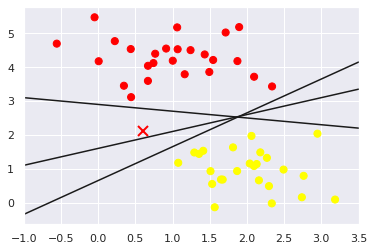

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

> These are three *very* different separators which, nevertheless, perfectly discriminate between these samples.
Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label!
Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

上图中有三条非常不同的分割线，但是都能完美的区分这些样本。取决于你选择了哪条直线，新数据点（例如图中标记为"X"的点）会被判定为不同的标签。显然简单的“画一条线分类”的简单直觉是不够的，我们需要更加深入地考虑这个问题。

## Support Vector Machines: Maximizing the *Margin*

## 支持向量机：最大化边缘

> Support vector machines offer one way to improve on this.
The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a *margin* of some width, up to the nearest point.
Here is an example of how this might look:

支持向量机提供了一个方法来改进这个问题。这里的原理是：与其简单画一条0宽度的线来分类，我们可以每条线上画出一个有宽度的*边缘*，直至最近的点为止。下面是一个例子：

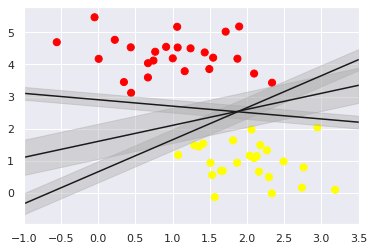

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

> In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model.
Support vector machines are an example of such a *maximum margin* estimator.

在支持向量机中，拥有最大化边缘的线就是我们需要选择的那个最优化模型。支持向量机是这样的*最大化边缘*评估器。

### Fitting a support vector machine

### 训练支持向量机

> Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data.
For the time being, we will use a linear kernel and set the ``C`` parameter to a very large number (we'll discuss the meaning of these in more depth momentarily).

下面我们来看看使用这个数据训练支持向量机模型的实际结果：我们会在这些数据上使用Scikit-Learn支持向量机分类器来训练一个SVM模型。目前我们先使用一个线性的核并且将`C`参数设置为非常大的数值（我们马上会深度讨论这些概念的含义）。

In [5]:
from sklearn.svm import SVC # 支持向量分类器
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

> To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

要更好的可视化展示这里发生的事情，我们创建一个快速的工具函数来绘制SVM的边界：

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """绘制2D SVC图像函数"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # 创建网格来展示数据
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # 绘制边界和边缘
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # 绘制支持向量
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

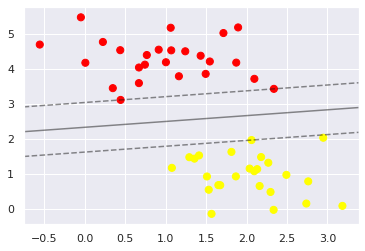

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

> This is the dividing line that maximizes the margin between the two sets of points.
Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure.
These points are the pivotal elements of this fit, and are known as the *support vectors*, and give the algorithm its name.
In Scikit-Learn, the identity of these points are stored in the ``support_vectors_`` attribute of the classifier:

这条分割线将连个分类之间的间隔最大化了。注意到其中某些点正好接触到边缘：可以看到上图中黑色虚线穿过的点。这些点是这个模型训练的关键元素，被称为*支持向量*，也是这个算法名称的由来。在Scikit-Learn中，这些点的数据被保存在分类器的`support_vectors_`属性中：

In [8]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

> A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit!
Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

这个分类器成功的关键是在拟合过程中，只有哪些支持向量的位置才有意义；任何其他超出边缘范围的点都不会改变训练结果。技术上来说，这是因为这些点并不会为损失函数提供任何贡献来拟合模型，所以它们不会通过边缘区域，它们的位置和数值没有意义。

> We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

可以绘制这个模型通过前60个点的拟合结果以及前120个点的拟合结果来看到这一点：

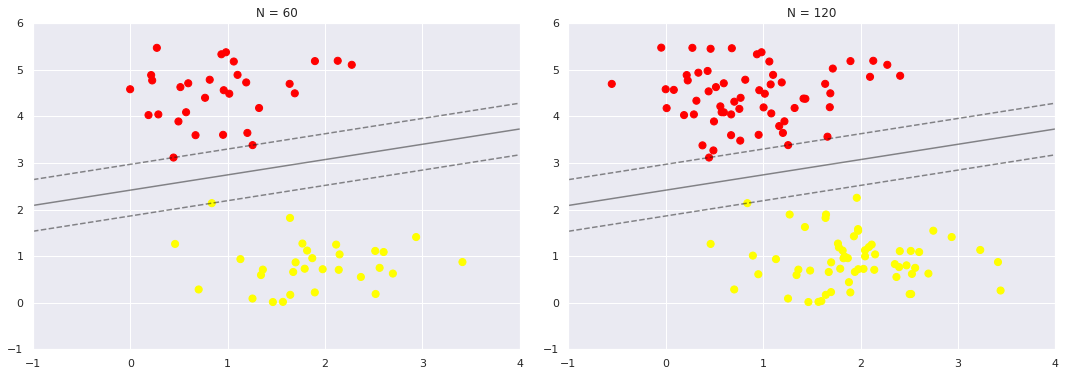

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

> In the left panel, we see the model and the support vectors for 60 training points.
In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel.
This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

左图中，我们看到前60个点生成的模型和支持向量。右图中有两倍数量的训练点，但是模型并未发生变化：左右两图中的三个支持向量是相同的。这种对于远离分隔区域的点的不敏感性是SVM模型的威力所在。

> If you are running this notebook live, you can use IPython's interactive widgets to view this feature of the SVM model interactively:

如果你是在notebook中实时运行本节的话，你可以使用IPython的交互组件来动态展示SVM模型特征：

In [10]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 200), value=10), Output()), _dom_classes=('widget…

### Beyond linear boundaries: Kernel SVM

### 超出线性限制：核SVM

> Where SVM becomes extremely powerful is when it is combined with *kernels*.
We have seen a version of kernels before, in the basis function regressions of [In Depth: Linear Regression](05.06-Linear-Regression.ipynb).
There we projected our data into higher-dimensional space defined by polynomials and Gaussian basis functions, and thereby were able to fit for nonlinear relationships with a linear classifier.

当SVM与*核*组合之后，它会变得异常强大。我们前面已经看到一个核的版本，就在[深入：线性回归](05.06-Linear-Regression.ipynb)中介绍过的基本函数回归。那个例子中我们将数据使用多项式和高斯函数投射到高维度空间中，然后就能使用线性分类器来拟合非线性的关系。

> In SVM models, we can use a version of the same idea.
To motivate the need for kernels, let's look at some data that is not linearly separable:

在SVM模型中，我们可以使用相同的思想。为了让我们看到核的作用，使用下面非线性分割的数据：

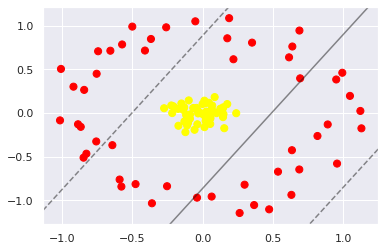

In [11]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

> It is clear that no linear discrimination will *ever* be able to separate this data.
But we can draw a lesson from the basis function regressions in [In Depth: Linear Regression](05.06-Linear-Regression.ipynb), and think about how we might project the data into a higher dimension such that a linear separator *would* be sufficient.
For example, one simple projection we could use would be to compute a *radial basis function* centered on the middle clump:

很明显没有线性分类器能够将这些数据点分开。但是我们可以从[深入：线性回归](05.06-Linear-Regression.ipynb)一节中的基本函数回归里面类推过来，同样的将数据投射到更高的维度，然后线性分类器就可以达到划分数据的目标。例如下面使用的以中央的数据群为中心的*径向基函数*：

In [12]:
r = np.exp(-(X ** 2).sum(1))

> We can visualize this extra data dimension using a three-dimensional plot—if you are running this notebook live, you will be able to use the sliders to rotate the plot:

可以使用三维图表将这个转换后的数据可视化出来，如果我们使用的是notebook交互模式，甚至还可以使用滑块旋转这个图表：

In [13]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(Dropdown(description='elev', options=(-90, 90), value=-90), IntSlider(value=30, descript…

> We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, *r*=0.7.

然后我们可以看到有了额外的维度后，数据变得线性可分，比方说我们可以在*r*=0.7的位置画出一条分割线。

> Here we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results.
In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

这个例子中我们需要仔细的选择和调整我们的投射方式：如果我们没有将径向基函数的中心点放置在正确的位置上，就不能找到这样清晰的线性分割线出来。通常这样的选择是一个问题：我们希望有一种自动选择最佳基函数的方法。

> One strategy to this end is to compute a basis function centered at *every* point in the dataset, and let the SVM algorithm sift through the results.
This type of basis function transformation is known as a *kernel transformation*, as it is based on a similarity relationship (or kernel) between each pair of points.

一个实现的方法是在数据集中的*每个*数据点作为中心点计算基函数，然后让SVM算法帮我们从结果中筛选出好的基函数。这种基函数转换被成为*核转换*，因为它建立在每一对数据点之间相似的关系（或称为核）的基础之上。

> A potential problem with this strategy—projecting $N$ points into $N$ dimensions—is that it might become very computationally intensive as $N$ grows large.
However, because of a neat little procedure known as the [*kernel trick*](https://en.wikipedia.org/wiki/Kernel_trick), a fit on kernel-transformed data can be done implicitly—that is, without ever building the full $N$-dimensional representation of the kernel projection!
This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

这种方法的潜在问题是，将$N$个点投射到$N$个维度上是非常消耗计算资源的，特别是$N$增大的情况下。但是因为存在一个被称为[*核技巧*](https://en.wikipedia.org/wiki/Kernel_trick)的过程，在核转换的数据上的拟合可以被隐式完成，也就是说不需要构建完整的$N$为核投射数据就可以完成训练。这个和技巧內建在SVM中，因此是这个算法如此强大的原因之一。

> In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the ``kernel`` model hyperparameter:

在Scikit-Learn中我们要应用核化的SVM，只需要简单将线性的核改为RBF（径向基函数）核，通过设置模型的`kernel`超参数即可：

In [15]:
clf = SVC(kernel='rbf', C=1E6, gamma='auto')
clf.fit(X, y)

SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

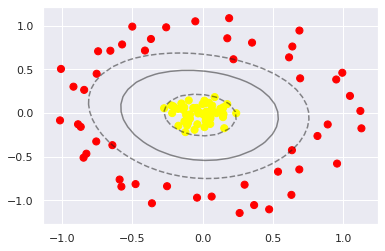

In [16]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

> Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary.
This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

使用这个核化的支持向量机，我们得到了一条合适的非线性决定边界。这种核转换策略经常在机器学习中被使用在将线性方法转变为快速的非线性方法的场合，特别适合能运用核技巧的模型中。

### Tuning the SVM: Softening Margins

### SVM调优：软化边缘

> Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists.
But what if your data has some amount of overlap?
For example, you may have data like this:

我们目前讨论集中在非常干净的数据集上，也就是存在着完美的决定边界。如果数据中存在一些重叠的话会怎么样？如下面看到的数据：

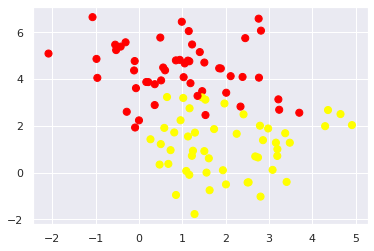

In [17]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

> To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit.
The hardness of the margin is controlled by a tuning parameter, most often known as $C$.
For very large $C$, the margin is hard, and points cannot lie in it.
For smaller $C$, the margin is softer, and can grow to encompass some points.

要处理这种情况，SVM提供了一些附加因素用于*软化边缘*：意思就是，它允许一些数据点潜入到边缘区域，如果这样能达到更好的拟合效果的话。边缘的硬度被一个称为$C$的可调参数控制。如果$C$的值很大，边缘是硬的，也就是数据点无法进入边缘区域。如果$C$的值比较小，边缘是软的，能够蔓延到点之外。

> The plot shown below gives a visual picture of how a changing $C$ parameter affects the final fit, via the softening of the margin:

下面的图表展示了使用边缘软化技术，调整了$C$参数之后影响到最终拟合的情况：

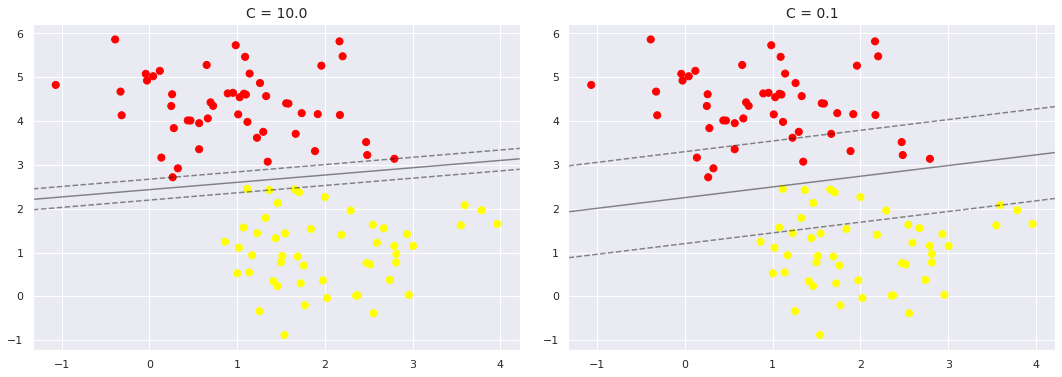

In [18]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

> The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation or a similar procedure (refer back to [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb)).

最优的$C$值取决于你的数据集，应该通过交叉验证或者简单过程（参见[超参数和模型验证](05.03-Hyperparameters-and-Model-Validation.ipynb)）来调整。

## Example: Face Recognition

## 例子：人脸识别

> As an example of support vector machines in action, let's take a look at the facial recognition problem.
We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.
A fetcher for the dataset is built into Scikit-Learn:

作为支持向量机的一个实际例子，让我们来看一下人脸识别问题。我们使用的是一个标注好的数据集，其中包含着几千张公众人物的脸部照片。Scikit-Learn內建了获取数据集的方法：

In [20]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


> Let's plot a few of these faces to see what we're working with:

我们将其中一些脸谱画出来看一下：

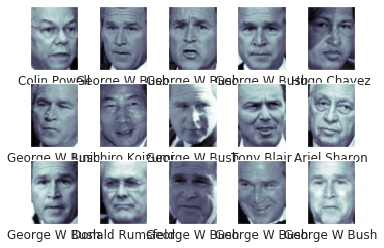

In [21]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

> Each image contains [62×47] or nearly 3,000 pixels.
We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use a principal component analysis (see [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb)) to extract 150 fundamental components to feed into our support vector machine classifier.
We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

每张图像含有[62×47]或者说将近3000像素点。我们可以使用每个像素点作为数据集的一个特征，但是通常来说更有效的做法是采用一些预处理器来提取图像中有意义的特征；这里我们将采用主成分分析（参见[深入：主成分分析](05.09-Principal-Component-Analysis.ipynb)）来提取图像中150个基础成分，然后输入到支持向量机分类器中。最简单完成这项任务的方式是将预处理器和分类器连接成一个管道：

In [23]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

> For the sake of testing our classifier output, we will split the data into a training and testing set:

为了验证我们分类器的性能，我们将数据分成训练集和测试集：

In [25]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

> Finally, we can use a grid search cross-validation to explore combinations of parameters.
Here we will adjust ``C`` (which controls the margin hardness) and ``gamma`` (which controls the size of the radial basis function kernel), and determine the best model:

最后，我们可以使用网格查找交叉验证来验证我们的模型超参数的组合。这里我们会调整`C`（用来控制边缘硬度）和`gamma`（用来控制径向基函数核的大小），然后找到最佳模型：

In [28]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid, cv=3)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 1min 32s, sys: 919 ms, total: 1min 33s
Wall time: 31.4 s
{'svc__C': 10, 'svc__gamma': 0.001}


> The optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum.

最优值应该落在网格的中央位置；如果它们落在边缘位置，我们应该考虑扩大网格来确保我们找到了最优值。

> Now with this cross-validated model, we can predict the labels for the test data, which the model has not yet seen:

现在我们有了经过交叉验证后的模型，可以用来预测测试数据上的标签了，这些数据模型都没有接触过：

In [29]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

> Let's take a look at a few of the test images along with their predicted values:

下面我们看一下测试照片以及它们对应的预测标签值：

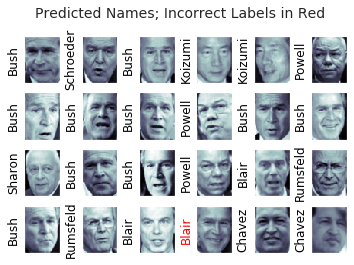

In [30]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

> Out of this small sample, our optimal estimator mislabeled only a single face (Bush’s
face in the bottom row was mislabeled as Blair).
We can get a better sense of our estimator's performance using the classification report, which lists recovery statistics label by label:

在这个小样本中，我们优化过的评估器仅标错了一个人的脸（最下面一行布什的脸被错误的标记成了布莱尔）。我们可以使用分类报告更好的得到评估器的性能估计，报告中我们对每个标签都进验证得出统计数据：

In [31]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

         accuracy                           0.85       337
        macro avg       0.83      0.84      0.84       337
     weighted avg       0.86      0.85      0.85       337



> We might also display the confusion matrix between these classes:

当然我们也可以绘制这些分类之间的粗混淆矩阵：

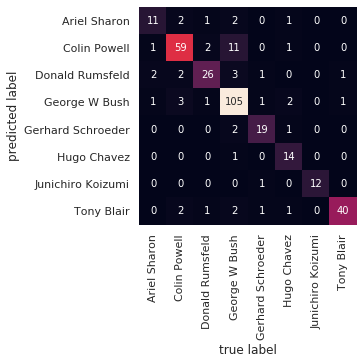

In [32]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

> This helps us get a sense of which labels are likely to be confused by the estimator.

上面的矩阵能帮助我们建立评估器在每个标签上性能的直观印象。

> For a real-world facial recognition task, in which the photos do not come pre-cropped into nice grids, the only difference in the facial classification scheme is the feature selection: you would need to use a more sophisticated algorithm to find the faces, and extract features that are independent of the pixellation.
For this kind of application, one good option is to make use of [OpenCV](http://opencv.org), which, among other things, includes pre-trained implementations of state-of-the-art feature extraction tools for images in general and faces in particular.

在真实的人脸识别任务中，人脸的照片并没有预先裁剪成一个网格，与例子中的唯一区别在于特征选择部分：你可能需要使用一个复杂得多的算法来找到人脸，并将其中像素中独立的特征提取出来。对于这类应用，[OpenCV](http://opencv.org)是一个很好的选择，因为它其中已经內建了预训练的特征提取工具实现，无论是通用的图像还是人脸的照片。

## Support Vector Machine Summary

## 支持向量机总结

> We have seen here a brief intuitive introduction to the principals behind support vector machines.
These methods are a powerful classification method for a number of reasons:

> - Their dependence on relatively few support vectors means that they are very compact models, and take up very little memory.
- Once the model is trained, the prediction phase is very fast.
- Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is a challenging regime for other algorithms.
- Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

本节内容对支持向量机背后的原理进行了简要直观的介绍。这些方法在分类任务中非常强大的原因在于：

- 它们仅依赖于很少的支持向量，这意味着它们是非常紧凑的模型，占用的内存也非常少。
- 一旦模型训练好了，预测阶段非常快速。
- 因为它们仅受到边缘区域附近数据点的影响，所以它们在高维度数据上也工作良好，甚至数据的特征维度比样本数还多的情况下。这对于其他算法来说都是一个具挑战性的领域。
- 将它们与核方法集成之后将会非常灵活强大，能够使用多种类型的数据。

> However, SVMs have several disadvantages as well:

> - The scaling with the number of samples $N$ is $\mathcal{O}[N^3]$ at worst, or $\mathcal{O}[N^2]$ for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
- The results are strongly dependent on a suitable choice for the softening parameter $C$. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
- The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the ``probability`` parameter of ``SVC``), but this extra estimation is costly.

当然，SVM也有如下一些缺点：

- 算法复杂度在样本数为$N$的情况下，最差是$\mathcal{O}[N^3]$，最好实现是$\mathcal{O}[N^2]$。这导致训练集特别大的情况下，这个计算代价是无法承受的。
- 算法的性能结果很大程度上依赖于边缘软化参数$C$的选择。这需要通过交叉验证来小心选择，在数据集增大时该操作也是非常昂贵的。
- 结果没有直接的概率解释。虽然可以通过内部的交叉验证（参见`SVC`分类器的`probability`参数）来估计，但是要更精确的估算是困难的。

> With those traits in mind, I generally only turn to SVMs once other simpler, faster, and less tuning-intensive methods have been shown to be insufficient for my needs.
Nevertheless, if you have the CPU cycles to commit to training and cross-validating an SVM on your data, the method can lead to excellent results.

有了上面的特性，作者通过仅会在其他简单快速和更少超参调节的方法无法满足的情况下采用SVM。然而，如果你有很好的计算资源来完成SVM的训练和交叉验证的话，这个方法能提供优异的结果。

<!--NAVIGATION-->
< [In Depth: Linear Regression](05.06-Linear-Regression.ipynb) | [Contents](Index.ipynb) | [In-Depth: Decision Trees and Random Forests](05.08-Random-Forests.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
